## Objective:

Our main objective for this analysis is to train a model which can seperate the postive and negative reviews.

In this problem we will apply clustering techniques called Agglomerative-Clustering to get an idea if the data can be clustered based on the reviews the model finds to be similar.

## Importing Libraries & getting Data


In [1]:
import numpy as np 
import pandas as pd 
import sqlite3 
import matplotlib.pyplot as plt 
import seaborn as sns 

import re 
import math 
import os 
import string 
from tqdm import tqdm 

import warnings 
warnings.filterwarnings('ignore')

# Metrics libraries
from sklearn.metrics import accuracy_score ,confusion_matrix, roc_curve, auc ,roc_auc_score

# NLP libraries 
import nltk 
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer 
from nltk.stem.wordnet import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from gensim.models import Word2Vec 
from gensim.models import KeyedVectors

import tensorflow as tf
from tensorflow.python.client import device_lib

In [2]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(device_lib.list_local_devices())

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7591716129747420027
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1753127323
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11159267358668305405
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [4]:
connection = sqlite3.connect('G:/My Drive/datasets/amazon food review/dataset/database.sqlite')

# ignoring datapoints where score = 3 (neutral review)

filtered_data = pd.read_sql_query("""
SELECT * 
FROM Reviews
WHERE Score != 3
LIMIT 50000
""", connection)

In [5]:
# label encoding score into positive (x>3) and negative (x<3)

def partition(x):
    if x < 3:
        return 0
    else:
        return 1


score_with_neutral = filtered_data['Score']
score_wo_neutral = score_with_neutral.map(partition)

filtered_data['Score'] = score_wo_neutral

In [6]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      50000 non-null  int64 
 1   ProductId               50000 non-null  object
 2   UserId                  50000 non-null  object
 3   ProfileName             50000 non-null  object
 4   HelpfulnessNumerator    50000 non-null  int64 
 5   HelpfulnessDenominator  50000 non-null  int64 
 6   Score                   50000 non-null  int64 
 7   Time                    50000 non-null  int64 
 8   Summary                 50000 non-null  object
 9   Text                    50000 non-null  object
dtypes: int64(5), object(5)
memory usage: 3.8+ MB


In [8]:
filtered_data.shape

(50000, 10)

In [9]:
display = pd.read_sql_query("""
SELECT UserId, ProductId ,ProfileName ,Time, Score ,Text ,COUNT(*)
FROM Reviews 
GROUP BY UserId 
HAVING COUNT(*) > 1
""", connection)

display.head()

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [10]:
display.shape

(80668, 7)

In [11]:
display['COUNT(*)'].sum()

393063

# EDA

## Data Cleaning (Removing Duplicates)

In [12]:
display = pd.read_sql_query("""
SELECT * 
FROM Reviews 
WHERE Score != 3 AND UserId='#oc-R11D9D7SHXIJB9'
ORDER BY ProductId
""", connection)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,455534,B005HG9ERW,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
1,290948,B005HG9ESG,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
2,496894,B005HG9ET0,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."


#### NOTE : 
- It can be seen that same user has multiple reviews with same values for all the parameters.

- So, in order to get unbiased results ,we need to remove the rows having same parameters.

- Steps to do so : 
    - first sort the data according to ProductId in ascending order.
    - Then just keep the first similar product review and delete the others


In [13]:
sorted_data = filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
clean_data = sorted_data.drop_duplicates(
    subset={"UserId", "ProfileName", "Time", "Text"}, keep='first', inplace=False)

clean_data.shape

(46072, 10)

# Data Preprocessing

#### Steps : 

1. Begin by removing the HTML tags

2. Remove any punctuations or limited set of special characters like , or . etc

3. Check if the word is made up of english letters and is not alpha-numeric.

4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)

5. Convert the words to lowercase

6. Remove Stopwords

7. Stemming the word 


In [14]:
# sample reviews

review_1 = clean_data['Text'].values[0]
print(review_1)
print('---------------------------------------')

review_2 = clean_data['Text'].values[1]
print(review_2)
print('---------------------------------------')

review_3 = clean_data['Text'].values[2]
print(review_3)


My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
---------------------------------------
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
---------------------------------------
Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


### 1. Removing URLs


In [15]:
review_1 = re.sub('http\S+', "", review_1)
review_2 = re.sub('http\S+', "", review_2)
review_3 = re.sub('http\S+', "", review_3)


### 2. Removing HTML tags


In [16]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(review_1, 'lxml')
review_1 = soup.get_text()

soup = BeautifulSoup(review_2, 'lxml')
review_2 = soup.get_text()

soup = BeautifulSoup(review_3, 'lxml')
review_3 = soup.get_text()

### 3. Removing Apostrophes

In [17]:
def removing_apostrophes(text):
    # general
    text = re.sub("n\'t", " not", text)
    text = re.sub("\'re", " are", text)
    text = re.sub("\'s", " is", text)
    text = re.sub("\'d", " would", text)
    text = re.sub("\'ll", " will", text)
    text = re.sub("\'t", " not", text)
    text = re.sub("\'ve", " have", text)
    text = re.sub("\'m", " am", text)

    text = re.sub("won't", "will not", text)
    text = re.sub("can\'t", "can not", text)

    return text

    
# isn't gets converted to 'is not' in line 3
review_3 = removing_apostrophes(review_3)
print(review_3)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


### 4. Removing Numbers / Punctuations /Special Characters

In [18]:
# removing numbers
review_1 = re.sub('\S*\d\S*', "", review_1).strip()
print(review_1)
print('-----------------------------------------')

# removing special characters
review_3 = re.sub('[^A-Za-z0-9]+', ' ', review_3)
print(review_3)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
-----------------------------------------
Why is this when the same product is available for here The Victor M380 and M502 traps are unreal of course total fly genocide Pretty stinky but only right nearby 


### 5. Removing Stopwords

In [19]:
# removing the following words from the stop words list: 'no', 'nor', 'not'

stopwords = set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",
                "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself',
                 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',
                 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those',
                 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
                 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of',
                 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',
                 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',
                 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
                 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very',
                 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're',
                 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',
                 "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
                 "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't",
                 'won', "won't", 'wouldn', "wouldn't"])

### Combining all Steps

In [20]:
from tqdm import tqdm
preprocessed_reviews = []

for text in tqdm(clean_data['Text'].values):
    text = re.sub('http\S+', "", text)
    text = BeautifulSoup(text, 'lxml').get_text()

    text = removing_apostrophes(text)

    text = re.sub('\S*\d\S*', "", text).strip()
    text = re.sub('[^A-Za-z0-9]+', ' ', text)

    text = ' '.join(i.lower()
                    for i in text.split() if i.lower() not in stopwords)

    preprocessed_reviews.append(text.strip())

100%|██████████| 46072/46072 [00:24<00:00, 1900.71it/s]



## Splitting into train and test sets

In [21]:
preprocessed_reviews = preprocessed_reviews[:10000]

X = preprocessed_reviews
y = np.array(clean_data['Score'])

## WordCloud

In [22]:
def wordcloud(model, optimal_K, X):
    labels = model.labels_
    cluster_dict = {i: np.where(labels == i)[0] for i in range(optimal_K)}

    for cluster_number in range(optimal_K):
        cluster = [cluster_dict[cluster_number][i]
                   for i in range(cluster_dict[cluster_number].size)]

        reviews_cluster = []
        for i in cluster:
            reviews_cluster.append(X[i])

        review_corpus = ''
        for review in reviews_cluster:
            review_corpus = review_corpus + ' ' + review

        # wordcloud
        wordclouds = WordCloud(width=800, height=400, margin=2,scale=1, max_words=75, min_font_size=5,random_state=42, background_color='black', contour_color='black', repeat=False).generate(str(review_corpus))

        plt.figure(figsize=(16, 8))
        plt.title("WordCloud for Cluster {}".format(cluster_number))
        plt.imshow(wordclouds, interpolation='bilinear')
        plt.axis('off')
        plt.show()

# Models

In [23]:
from sklearn.cluster import AgglomerativeClustering
from wordcloud import WordCloud

## 1. AVG-W2V


In [24]:
#word2vec for train data

sent_list_train = []
sent_vectors_train = []

for sentence in X:
    sent_list_train.append(sentence.split())

w2v_model = Word2Vec(sent_list_train, min_count=5, vector_size=50, workers=4)
w2v_words = list(w2v_model.wv.index_to_key)


for sent in tqdm(sent_list_train):
    sent_vectors = np.zeros(50)
    count_words = 0

    for word in sent:
        if word in w2v_words:
            vectors = w2v_model.wv[word]
            sent_vectors += vectors
            count_words += 1

    if count_words != 0:
        sent_vectors /= count_words

    sent_vectors_train.append(sent_vectors)

print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|██████████| 10000/10000 [00:06<00:00, 1473.68it/s]

10000
50


In [25]:
X_avg_w2v = sent_vectors_train

### 1.1 Dendrogram (AVG-W2V)

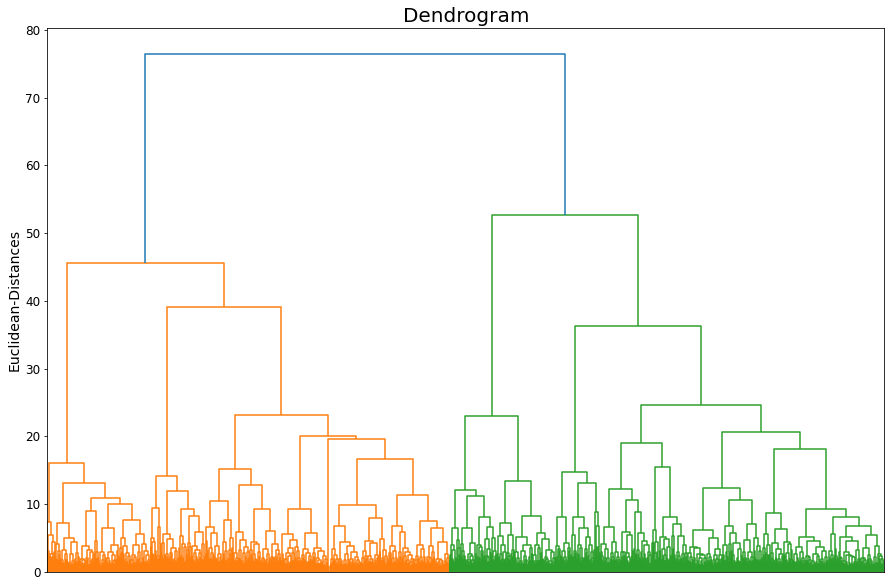

In [26]:
import scipy.cluster.hierarchy as sch 

plt.figure(figsize=(15,10))

dendrogram = sch.dendrogram(sch.linkage(X_avg_w2v ,method='ward'))
plt.title('Dendrogram', fontsize=20)

plt.ylabel('Euclidean-Distances', fontsize=14)
plt.xticks([], [])
plt.yticks(fontsize=12)

plt.show()


In [41]:
# inferred from dendrogram
optimal_clusters_avg_w2v = 4

### 1.2 Cophenetic Correlation (AVG-W2V)

In [38]:
from scipy.cluster.hierarchy import cophenet
coph_ceff = np.mean(cophenet(sch.linkage(X_avg_w2v)))

print('The cophenetic correlation is : {}'.format(coph_ceff))

The cophenetic correlation is : 0.592360094565701


### 1.3 Model Building (AVG-W2V)

In [42]:
model_avg_w2v = AgglomerativeClustering(n_clusters=optimal_clusters_avg_w2v)
model_avg_w2v.fit(X_avg_w2v)

y_pred_avg_w2v = model_avg_w2v.fit_predict(X_avg_w2v)

### 1.4 Cluster Analysis (AVG-W2V)

In [43]:
cluster_num = pd.DataFrame(y_pred_avg_w2v ,columns=['Cluster_number'])
cluster_num

,Cluster_number
0,3
1,3
2,0
3,0
4,0
...,...
9995,0
9996,3
9997,3
9998,3


In [44]:
new_data = pd.concat([clean_data ,cluster_num] ,axis=1)
new_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cluster_number
0,1.0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1.0,1.0,1.0,1.303862e+09,Good Quality Dog Food,I have bought several of the Vitality canned d...,3.0
1,2.0,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0.0,0.0,0.0,1.346976e+09,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,3.0
2,3.0,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1.0,1.0,1.0,1.219018e+09,"""Delight"" says it all",This is a confection that has been around a fe...,0.0
3,4.0,B000UA0QIQ,A395BORC6FGVXV,Karl,3.0,3.0,0.0,1.307923e+09,Cough Medicine,If you are looking for the secret ingredient i...,0.0
4,5.0,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0.0,0.0,1.0,1.350778e+09,Great taffy,Great taffy at a great price. There was a wid...,0.0


In [45]:
new_data.groupby(['Cluster_number'])['Text'].count()

Cluster_number
0.0    3342
1.0    3724
2.0    1163
3.0    1135
Name: Text, dtype: int64

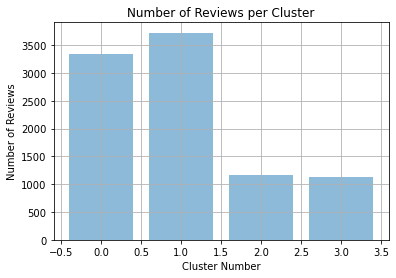

In [46]:
plt.bar([x for x in range(optimal_clusters_avg_w2v)], new_data.groupby(
    ['Cluster_number'])['Text'].count(), alpha=0.5)

plt.title('Number of Reviews per Cluster')
plt.grid()
plt.xlabel('Cluster Number')
plt.ylabel('Number of Reviews')
plt.show()

### 1.5 WordCloud (AVG-W2V)

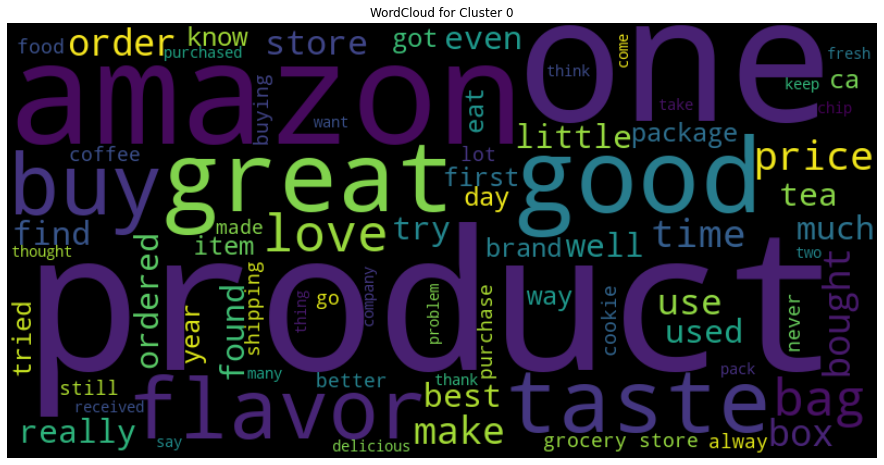

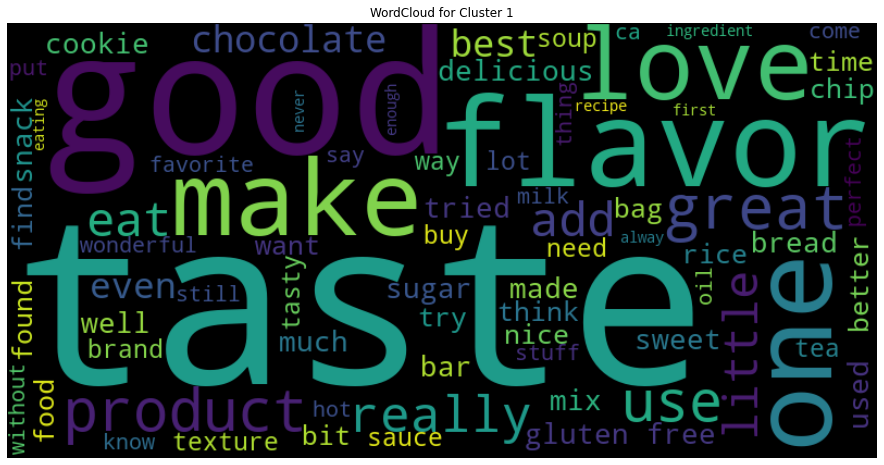

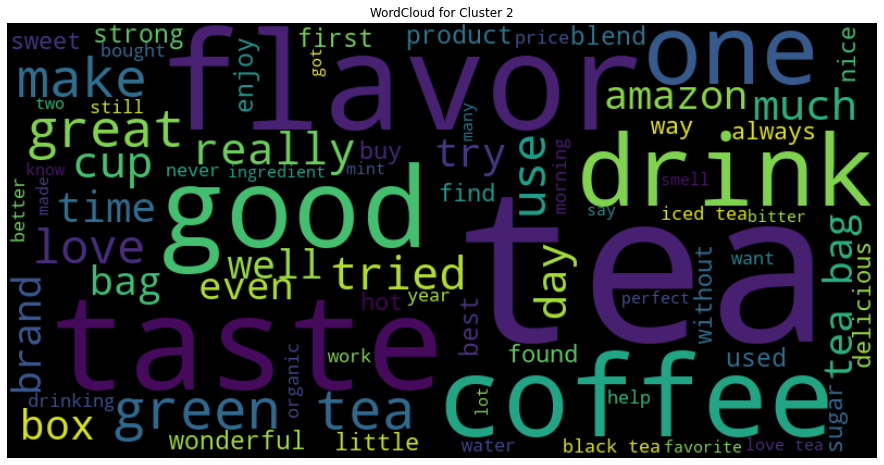

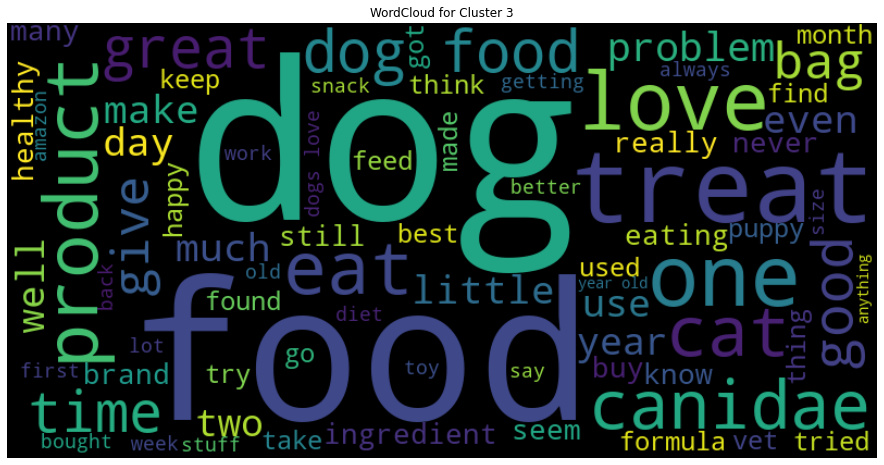

In [47]:
wordcloud(model_avg_w2v ,optimal_clusters_avg_w2v ,X)

## 2. TFIDF - W2V

In [48]:
sent_list_train = []

for sentence in X:
    sent_list_train.append(sentence.split())
    
w2v_model = Word2Vec(sent_list_train ,min_count=5 ,vector_size=50 ,workers=4)
w2v_words = list(w2v_model.wv.index_to_key)


tfidf_vectors = TfidfVectorizer(ngram_range=(1,2) ,min_df=10 ,max_features=500)
tfidf_matrix = tfidf_vectors.fit_transform(X)

tfidf_features = tfidf_vectors.get_feature_names()
tfidf_dictionary = dict(zip(tfidf_vectors.get_feature_names() ,list(tfidf_vectors.idf_)))


#word2vec for train data

tfidf_sent_vectors_train = []
row = 0

for sent in tqdm(sent_list_train):
    sent_vectors = np.zeros(50)
    weight_sum = 0 
    
    for word in sent:
        if word in w2v_words and word in tfidf_features:
            vectors = w2v_model.wv[word]
            tfidf = tfidf_dictionary[word]*(sent.count(word) / len(sent))
            sent_vectors += (vectors * tfidf) 
            weight_sum += tfidf
            
    if weight_sum != 0:
        sent_vectors /= weight_sum 
        
    tfidf_sent_vectors_train.append(sent_vectors)
    row +=1

100%|██████████| 10000/10000 [00:10<00:00, 916.27it/s]


In [49]:
X_tfidf_w2v = tfidf_sent_vectors_train

### 2.1 Dendrogram (TFIDF-W2V)

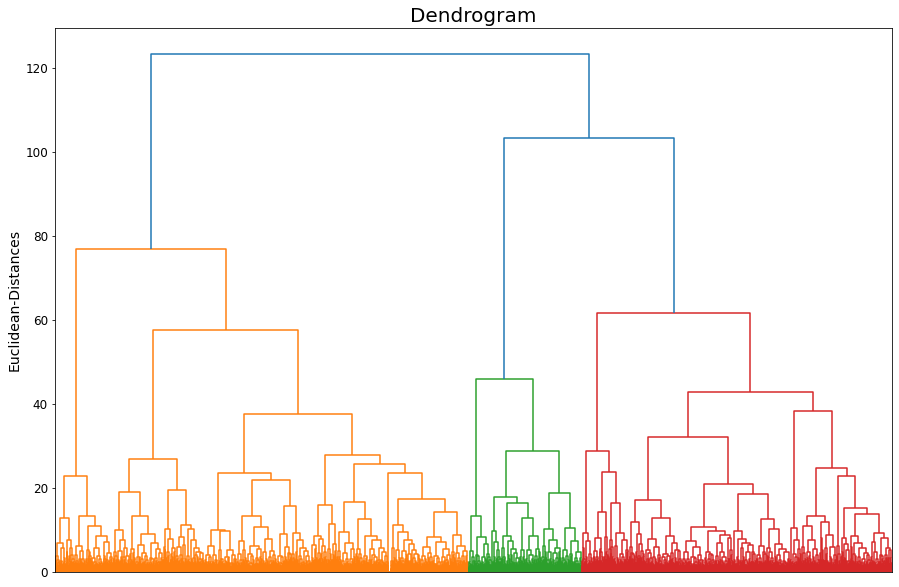

In [50]:
import scipy.cluster.hierarchy as sch

plt.figure(figsize=(15, 10))

dendrogram = sch.dendrogram(sch.linkage(X_tfidf_w2v, method='ward'))
plt.title('Dendrogram', fontsize=20)

plt.ylabel('Euclidean-Distances', fontsize=14)
plt.xticks([], [])
plt.yticks(fontsize=12)

plt.show()

In [51]:
# from dendrogram inferred
optimal_clusters_tfidf_w2v = 4

### 2.2 Cophenetic Correlation (TFIDF-W2V)

In [55]:
from scipy.cluster.hierarchy import cophenet
coph_coeff = np.mean(cophenet(sch.linkage(X_tfidf_w2v)))

print('The cophenetic correlation is : {}'.format(coph_coeff))

The cophenetic correlation is : 0.808754259241184


### 2.3 Model Building (TFIDF-W2V)

In [53]:
model_tfidf_w2v = AgglomerativeClustering(n_clusters=optimal_clusters_tfidf_w2v)
model_tfidf_w2v.fit(X_tfidf_w2v)

y_pred_tfidf_w2v = model_tfidf_w2v.fit_predict(X_tfidf_w2v)

### 2.4 Cluster Analysis (TFIDF-W2V)

In [56]:
cluster_num = pd.DataFrame(y_pred_tfidf_w2v, columns=['Cluster_number'])
cluster_num

,Cluster_number
0,1
1,1
2,1
3,1
4,1
...,...
9995,1
9996,3
9997,1
9998,1


In [57]:
new_data = pd.concat([clean_data ,cluster_num] ,axis=1)
new_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cluster_number
0,1.0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1.0,1.0,1.0,1.303862e+09,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0
1,2.0,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0.0,0.0,0.0,1.346976e+09,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,1.0
2,3.0,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1.0,1.0,1.0,1.219018e+09,"""Delight"" says it all",This is a confection that has been around a fe...,1.0
3,4.0,B000UA0QIQ,A395BORC6FGVXV,Karl,3.0,3.0,0.0,1.307923e+09,Cough Medicine,If you are looking for the secret ingredient i...,1.0
4,5.0,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0.0,0.0,1.0,1.350778e+09,Great taffy,Great taffy at a great price. There was a wid...,1.0


In [58]:
new_data.groupby(['Cluster_number'])['Text'].count()

Cluster_number
0.0    3500
1.0    3971
2.0    1259
3.0     634
Name: Text, dtype: int64

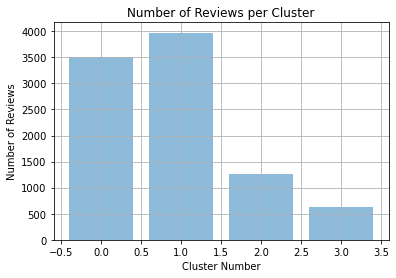

In [59]:
plt.bar([x for x in range(optimal_clusters_tfidf_w2v)],
        new_data.groupby(['Cluster_number'])['Text'].count(), alpha=0.5)

plt.title('Number of Reviews per Cluster')
plt.grid()
plt.xlabel('Cluster Number')
plt.ylabel('Number of Reviews')
plt.show()


### 2.4 WordCloud (TFIDF-W2V)

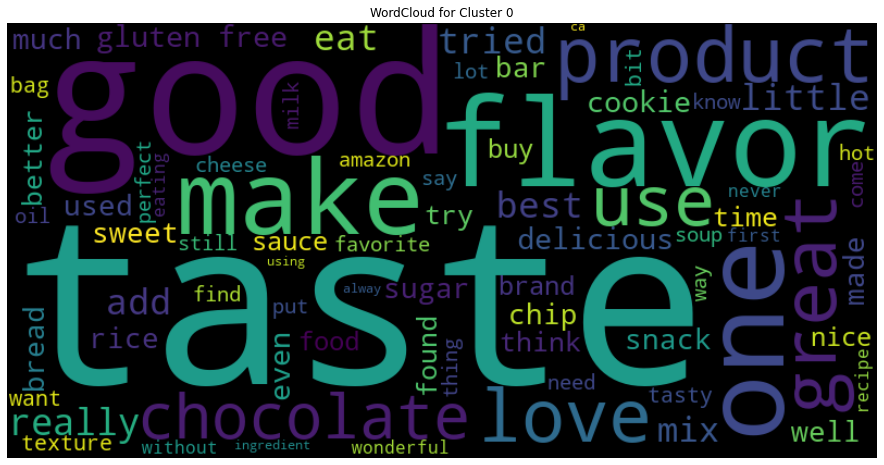

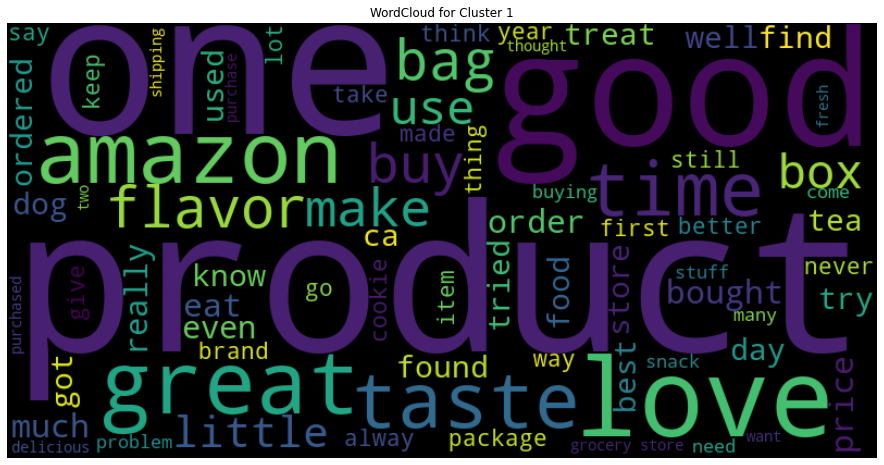

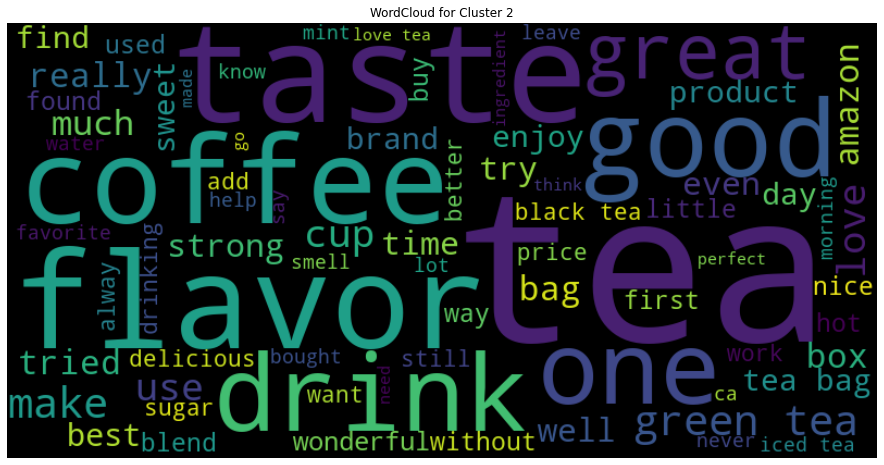

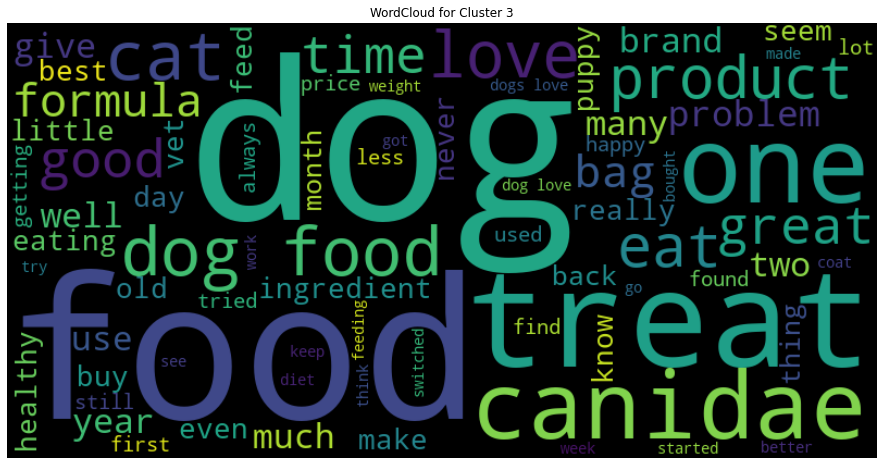

In [60]:
wordcloud(model_tfidf_w2v ,optimal_clusters_tfidf_w2v ,X)

# Model Comparision

### 1. Silhoutte Score

In [61]:
from sklearn.metrics import silhouette_score 

avg_w2v_score = silhouette_score(X_avg_w2v ,y_pred_avg_w2v)
print('Silhoutte Score for AVG-W2V is : {}'.format(avg_w2v_score))

tfidf_w2v_score = silhouette_score(X_tfidf_w2v, y_pred_tfidf_w2v)
print('Silhoutte Score for TFIDF-W2V is : {}'.format(tfidf_w2v_score))

Silhoutte Score for AVG-W2V is : 0.13411874906695742
Silhoutte Score for TFIDF-W2V is : 0.17264575041483834


### 2. Creating a prettytable to display comparision

In [62]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ['Vectorizer', 'Optimal-Clusters','Silhoutte-Score']
x.add_row(['AVG-W2V', 4, 0.13411])
x.add_row(['TFIDF-W2V', 4, 0.17264])

x.sortby = 'Silhoutte-Score'
x.reversesort = True
print(x)

+------------+------------------+-----------------+
| Vectorizer | Optimal-Clusters | Silhoutte-Score |
+------------+------------------+-----------------+
| TFIDF-W2V  |        4         |     0.17264     |
|  AVG-W2V   |        4         |     0.13411     |
+------------+------------------+-----------------+
